## Introduction

Although GSoC 2021 is close to come to an end, there's still a lot of exciting 
things going on around [Bambi](https://bambinos.github.io/bambi). Today I'm 
going to talk about another new family that's about to be merged into the main 
branch, the Binomial family. 

Let's get started by trying to see why we need to have another new family for
modeling binary data in Bambi.

## Aggregated vs disaggregated data


Bambi already has the Bernoulli family to model binary data.
This family fits very well when you have a data set where each row represents a 
single observation and there's a column that represents the binary outcome (
i.e the result of the Bernoulli trial) as well as other columns with the 
predictor variables.

Let's say we want to study the lethality of a certain drug and we have a group 
of mice to experiment with. An approach could be to divide the mice into smaller
groups, assign a certain dose to all the mice in each group, and then finally 
count the number of units that died after a fixed amount of time. Under
the Bernoulli family paradigm, each row has to represent a single observation,
looking like this:

<center>

| Obs | Dose | Died |
|----:|-----:|-----:|
| 1   | 1.3  | 0    |
| 2   | 1.8  | 1    |
| 3   | 2.2  | 1    |

</center>

where each row represents a single mouse (i.e. a single Bernoulli trial).
The **0** is used to represent a **failure/survival**, and **1** is used to 
represent a **successes/death**. 

What if our data is aggregated? The nature of the experiment makes it natural
to have rows representing groups, a column representing the number of deaths,
and another column representing the number of mice in the group.

<center>

| Group | Dose | Dead | Total |
|------:|-----:|-----:|------:|
| 1     | 1.3  | 12   | 20    |
| 2     | 1.8  | 18   | 25    |
| 3     | 2.2  | 24   | 34    |

</center>

where each row represents a group of mice. Dose is the dose applied to all the
units in the group, Dead is the number of mice that died, and 
Total is the number of mice in the group. If we focus on the **Dead** and 
**Total** columns we can easily see they resemble data coming from
a **Binomial distribution** (i.e. number of successes out of a series of $n$ 
independent Bernoulli trials). In other words, for a given row, we can think 
there's a Binomial distribution where **Dead** represents the number of 
successes out of **Total** number of trials (each mouse is a trial).

Before continuing, it's important to note that if the data is originally 
aggregated as in the lower table, it can always be disaggregated to resemble 
the one in the upper table. So what's the problem? 

The answer is that there's actually nothing wrong with having the data in such
a granular form! But, if the data already comes aggregated, why doing extra
work when we now have the Binomial family? Let's have a look at the examples
below!

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
az.style.use("arviz-darkgrid")
BLUE = "#003f5c"
PURPLE = "#7a5195"
PINK = "#ef5675"

We're going to use real data in this example^[This data can be found in An Introduction to Generalized Linear Models by A. J. Dobson and A. G. Barnett, but the original source is (Bliss, 1935).]. 
This data consists of the numbers of beetles dead after five hours of 
exposure to gaseous carbon disulphide at various concentrations:

<center>

| Dose, $x_i$ <br />($\log_{10}\text{CS}_2\text{mgl}^{-1}$)| Number of beetles, $n_i$ | Number killed, $y_i$ |
| --- | --- | --- |
| 1.6907 | 59 | 6 |
| 1.7242 | 60 | 13 |
| 1.7552 | 62 | 18 |
| 1.7842 | 56 | 28 |
| 1.8113 | 63 | 52 |
| 1.8369 | 59 | 53 |
| 1.8610 | 62 | 61 |
| 1.8839 | 60 | 60 |

</center>


In [3]:
x = np.array([1.6907, 1.7242, 1.7552, 1.7842, 1.8113, 1.8369, 1.8610, 1.8839])
n = np.array([59, 60, 62, 56, 63, 59, 62, 60])
y = np.array([6, 13, 18, 28, 52, 53, 61, 60])

data = pd.DataFrame({
    "x": x,
    "y": y,
    "n": n
})

Quite simple, right? Can we use it as it is with the Bernoulli family? Let's have a look below.

## Bernoulli family

Nope, no surprises today. To use the Bernoulli family, we first need to
transform the data into the dissagregated or long format. One approach is the 
following 

In [4]:
data_bernoulli = pd.DataFrame({
    "x": np.concatenate([np.repeat(x, n) for x, n in zip(x, n)]),
    "killed": np.concatenate([np.repeat([1, 0], [y, n - y]) for y, n in zip(y, n)])
})

Do you realize how bothering it can be to do that if we have many more 
variables? Nevermind, let's keep going.

Now let's initialize a Bambi model and sample from the posterior:

In [5]:
model_brn = bmb.Model("killed ~ x", data_bernoulli, family="bernoulli")
idata_brn = model_brn.fit()

Modeling the probability that killed==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
The acceptance probability does not match the target. It is 0.8794990003916735, but should be close to 0.8. Try to increase the number of tuning steps.


and explore the marginal posteriors

In [6]:
az.summary(idata_brn, kind="stats")

,mean,sd,hdi_3%,hdi_97%
Intercept,-60.917,5.188,-70.414,-51.186
x,34.382,2.918,28.968,39.777


We can predict the the probability of dying for out-of-sample data to see how
it evolves with the different concentration levels.

In [7]:
new_data = pd.DataFrame({"x": np.linspace(1.6, 2, num=200)})
model_brn.predict(idata_brn, data=new_data)

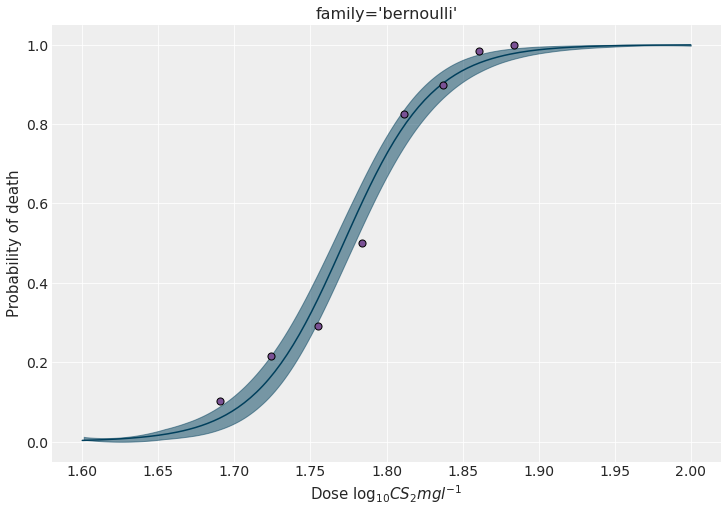

In [8]:
fig, ax = plt.subplots(figsize=(10, 7))

# Plot HDI for the mean of the probability of dying
az.plot_hdi(
  new_data["x"], 
  idata_brn.posterior["killed_mean"].values, 
  color=BLUE,
  ax=ax
)

ax.plot(
  new_data["x"], 
  idata_brn.posterior["killed_mean"].values.mean((0, 1)), 
  color=BLUE
)

ax.scatter(x, y / n, s=50, color=PURPLE, edgecolors="black", zorder=10)
ax.set_ylabel("Probability of death")
ax.set_xlabel(r"Dose $\log_{10}CS_2mgl^{-1}$")
ax.set_title("family='bernoulli'")

plt.show()

## Binomial family

Before writing down the model with the Binomial family, let's take a moment to
review new notation that was added specifically for this purpose.

The model formula syntax only allows us to pass one variable on its LHS. Then, 
how do we tell Bambi that what we want to model is the **proportion** that
results from dividing **y** over **n**?

Thanks to recent developments, it's as easy as writing `proportion(y, n)`, or
any of its aliases `prop(y, n)` and `p(y, n)`. To keep it shorter, let's use the
last one.

In [9]:
model_bnml = bmb.Model("p(y, n) ~ x", data, family="binomial")
idata_bnml = model_bnml.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


Quite simple, right? The code here is very similar to the one for the model with
the Bernoulli family. However, the new Binomial family allows us to
**use the data in its original form**.

Let's finish this section by getting the marginal posteriors as well as a figure
as the one displayed above.

In [10]:
az.summary(idata_bnml, kind="stats")

,mean,sd,hdi_3%,hdi_97%
Intercept,-61.053,5.095,-69.657,-50.276
x,34.462,2.861,28.477,39.293


In [11]:
model_bnml.predict(idata_bnml, data=new_data)

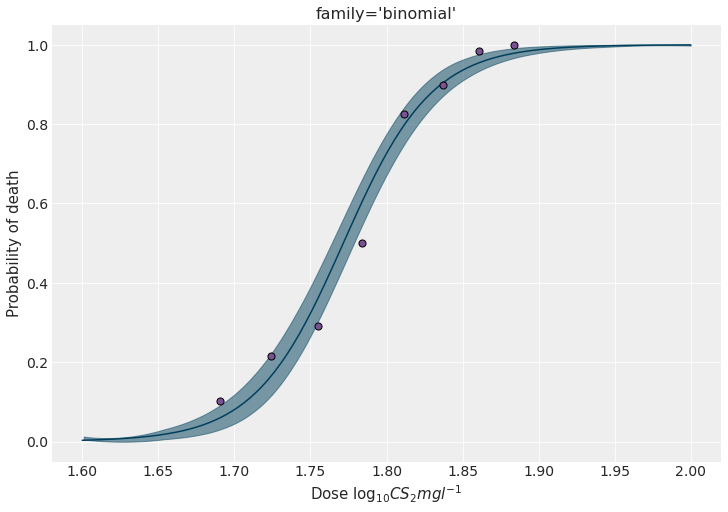

In [12]:
fig, ax = plt.subplots(figsize=(10, 7))

az.plot_hdi(
  new_data["x"],
  idata_bnml.posterior["p(y, n)_mean"].values,
  color=BLUE,
  ax=ax
)

ax.plot(
  new_data["x"], 
  idata_bnml.posterior["p(y, n)_mean"].values.mean((0, 1)), 
  color=BLUE
)

ax.scatter(x, y / n, s=50, color=PURPLE, edgecolors="black", zorder=10)
ax.set_ylabel("Probability of death")
ax.set_xlabel(r"Dose $\log_{10}CS_2mgl^{-1}$")
ax.set_title("family='binomial'")

plt.show()

## Conclusions

This blog post introduced the new Binomial family. This new family saves us 
from having to manipulate aggregated data prior to modeling, making it more 
pleasant and simpler to specify and fit models for binary data in Bambi.